# Implémentation et expérimentation de l'algorithme de construction d'arbres monotones

In [1]:
import numpy as np
import pandas as pd
import math
import random
from arbres import *
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline

### Création de la base jouet :

In [2]:
training_set = LabeledSet(2)

for i in range(0, 3):
    training_set.addExample([random.randint(0,2),random.randint(0,10)],1)
for i in range(0, 3):
    training_set.addExample([random.randint(3, 5), random.randint(0, 10)], 2)
for i in range(0, 4):
    training_set.addExample([random.randint(6, 10), random.randint(0,10)], 3)

In [3]:
df = pd.DataFrame(training_set.x, columns=['x1', 'x2'])
df['label'] = training_set.y
df

,x1,x2,label
0,1,9,1
1,1,9,1
2,2,6,1
3,4,9,2
4,3,4,2
5,4,6,2
6,10,1,3
7,9,6,3
8,8,4,3
9,8,0,3


### Ensembles dominants générés par un attribut/label

In [4]:
def dominant_sets_attribute(a_j, labeled_set):    
    '''
        a_j : index of attribute in labeled_set
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by a_j  
    '''
    values = labeled_set.x.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    for i in range(0, labeled_set.size()):
        v = labeled_set.getX(i)[a_j]
        dominant_sets[i] = set(values[values[:,a_j] >= v][:,labeled_set.getInputDimension()])
                
    return dominant_sets

def dominant_sets_label(labeled_set):
    '''
        labeled_set : labeled set
        for each object w in labeled_set, return its dominant set generated by its label  
    '''
    values = labeled_set.y.copy()
    ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
    values = np.hstack((values, ind))
    
    dominant_sets = dict()
    
    for i in range(0, labeled_set.size()):
        v = labeled_set.getY(i)
        dominant_sets[i] = set(values[values[:,0] >= v][:,1])
                
    return dominant_sets
    
dsa_1 = dominant_sets_attribute(0, training_set)
dsa_2 = dominant_sets_attribute(1, training_set)
dsl = dominant_sets_label(training_set)

In [5]:
df_dsa1 = pd.DataFrame(list(dsa_1.items())).drop(0, axis=1)
df_dsa1.columns = ['dominant set generated by first attribute']
df_dsa1

,dominant set generated by first attribute
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
2,"{2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 5, 6, 7, 8, 9}"
4,"{3, 4, 5, 6, 7, 8, 9}"
5,"{3, 5, 6, 7, 8, 9}"
6,{6}
7,"{6, 7}"
8,"{8, 9, 6, 7}"
9,"{8, 9, 6, 7}"


In [6]:
df_dsa2 = pd.DataFrame(list(dsa_2.items())).drop(0, axis=1)
df_dsa2.columns = ['dominant set generated by second attribute']
df_dsa2

,dominant set generated by second attribute
0,"{0, 1, 3}"
1,"{0, 1, 3}"
2,"{0, 1, 2, 3, 5, 7}"
3,"{0, 1, 3}"
4,"{0, 1, 2, 3, 4, 5, 7, 8}"
5,"{0, 1, 2, 3, 5, 7}"
6,"{0, 1, 2, 3, 4, 5, 6, 7, 8}"
7,"{0, 1, 2, 3, 5, 7}"
8,"{0, 1, 2, 3, 4, 5, 7, 8}"
9,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"


In [7]:
df_dsl = pd.DataFrame(list(dsl.items())).drop(0, axis=1)
df_dsl.columns = ['dominant set generated by label']
df_dsl

,dominant set generated by label
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
1,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
2,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}"
3,"{3, 4, 5, 6, 7, 8, 9}"
4,"{3, 4, 5, 6, 7, 8, 9}"
5,"{3, 4, 5, 6, 7, 8, 9}"
6,"{8, 9, 6, 7}"
7,"{8, 9, 6, 7}"
8,"{8, 9, 6, 7}"
9,"{8, 9, 6, 7}"


### Construction hiérarchique de mesures de discrimination

#### f-layer :

In [8]:
class F_layer:
    '''
        object-wise local monotonicity measure 
    '''
    def __init__(self, a_j):
        '''
            a_j : index of attribute in labeled_set
        '''
        self.a_j = a_j
        
    def value(self, w_i):
        raise NotImplementedError
        
    def equal_sets_attribute(self, labeled_set):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its equal set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[self.a_j]
            dominant_sets[i] = set(values[values[:,self.a_j] == v][:,labeled_set.getInputDimension()])

        return dominant_sets
    
    def equal_sets_label(self, labeled_set):    
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] == v][:,1])

        return dominant_sets
    
    def dominant_sets_attribute(self, labeled_set):    
        '''
            a_j : index of attribute in labeled_set
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by a_j  
        '''
        values = labeled_set.x.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()
        for i in range(0, labeled_set.size()):
            v = labeled_set.getX(i)[self.a_j]
            dominant_sets[i] = set(values[values[:,self.a_j] >= v][:,labeled_set.getInputDimension()])

        return dominant_sets

    def dominant_sets_label(self, labeled_set):
        '''
            labeled_set : labeled set
            for each object w in labeled_set, return its dominant set generated by its label  
        '''
        values = labeled_set.y.copy()
        ind = np.transpose(np.array([[i for i in range(labeled_set.size())]]))
        values = np.hstack((values, ind))

        dominant_sets = dict()

        for i in range(0, labeled_set.size()):
            v = labeled_set.getY(i)
            dominant_sets[i] = set(values[values[:,0] >= v][:,1])

        return dominant_sets

In [9]:
class Ds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return ds value of w_i, a_j
        '''
        esa_i = esa[w_i]
        esl_i = esl[w_i]
        intersection = esa_i.intersection(esl_i)
        
        return len(intersection) * 1.0 / len(esa_i)

In [10]:
ds_2 = Ds(1)
ds_2_values = []
esa = ds_2.equal_sets_attribute(training_set)
esl = ds_2.equal_sets_label(training_set)
for i in range(0, 10):
    ds_2_values.append(ds_2.value(i, training_set, esa, esl))
pd.DataFrame(ds_2_values, columns=['ds generated by second attribute'])

,ds generated by second attribute
0,0.666667
1,0.666667
2,0.333333
3,0.333333
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


$dsr(\omega_i)$ :

In [11]:
class Dsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return dsr value of w_i, a_j
        '''
        dsa_i = dsa[w_i]
        dsl_i = dsl[w_i]
        intersection = dsa_i.intersection(dsl_i)
        
        return len(intersection) * 1.0 / len(dsa_i)

In [12]:
dsr_1 = Dsr(0)
dsr_1_values = []
dsa = dsr_1.dominant_sets_attribute(training_set)
dsl = dsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_1_values.append(dsr_1.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_1_values, columns=['dsr generated by first attribute'])

,dsr generated by first attribute
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [593]:
dsr_2 = Dsr(1)
dsr_2_values = []
dsa = dsr_2.dominant_sets_attribute(training_set)
dsl = dsr_2.dominant_sets_label(training_set)

for i in range(0, 10):
    dsr_2_values.append(dsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(dsr_2_values, columns=['dsr generated by second attribute'])

,dsr generated by second attribute
0,1.000
1,1.000
2,1.000
3,0.625
4,0.600
5,0.700
6,0.400
7,0.375
8,0.400
9,0.400


In [13]:
class Minds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return minds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(equal_set)    

In [14]:
minds_2 = Minds(1)
minds_2_values = []
esa = minds_2.equal_sets_attribute(training_set)
esl = minds_2.equal_sets_label(training_set)

for i in range(0, 10):
    minds_2_values.append(minds_2.value(i,training_set, esa, esl))
pd.DataFrame(minds_2_values, columns=['minds generated by second attribute'])

,minds generated by second attribute
0,0.333333
1,0.333333
2,0.333333
3,0.333333
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


$mindsr(\omega_i)$

In [15]:
class Mindsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return mindsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []
        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
        return min(intersections_lengths) * 1.0 / len(dominant_set)    

In [17]:
mindsr_1 = Mindsr(0)
mindsr_1_values = []
dsa = mindsr_1.dominant_sets_attribute(training_set)
dsl = mindsr_1.dominant_sets_label(training_set)

for i in range(0, 10):
    mindsr_1_values.append(mindsr_1.value(i,training_set, dsa, dsl))
pd.DataFrame(mindsr_1_values, columns=['mindsr generated by first attribute'])

,mindsr generated by first attribute
0,0.100000
1,0.100000
2,0.125000
3,0.166667
4,0.142857
5,0.166667
6,1.000000
7,0.500000
8,0.250000
9,0.250000


$maxdsr(\omega_i)$

In [18]:
class Maxdsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            w_i : index of object in labeled_set
            return maxdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(dominant_set)    

In [19]:
class Maxds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            w_i : index of object in labeled_set
            return maxds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
    
    
        return max(intersections_lengths) * 1.0 / len(equal_set)    

$avgdsr(\omega_i)$

In [20]:
class Avgdsr(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, dsa, dsl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgdsr value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        dominant_set = dsa[w_i]
        
        for w_h in dominant_set:
            intersections_lengths.append(len(dsa[w_h].intersection(dsl[w_h])))
            
        return (1.0/len(dominant_set) * np.sum(intersections_lengths)) * 1.0 / len(dominant_set)    

In [21]:
class Avgds(F_layer):
    def __init__(self, a_j):
        super().__init__(a_j)
    
    def value(self, w_i, labeled_set, esa, esl):
        '''
            labeled_set : labeled set
            w_i : index of object in labeled_set
            return avgds value of w_i, a_j
        '''
        n = labeled_set.size()
        intersections_lengths = []

        equal_set = esa[w_i]
        
        for w_h in equal_set:
            intersections_lengths.append(len(esa[w_h].intersection(esl[w_h])))
            
        return (1.0/len(equal_set) * np.sum(intersections_lengths)) * 1.0 / len(equal_set)    

In [22]:
avgdsr_2 = Avgdsr(1)
avgdsr_2_values = []
dsa = avgdsr_2.dominant_sets_attribute(training_set)
dsl = avgdsr_2.dominant_sets_label(training_set)


for i in range(0, 10):
    avgdsr_2_values.append(avgdsr_2.value(i, training_set, dsa, dsl))
pd.DataFrame(avgdsr_2_values, columns=['avgdsr generated by second attribute'])

,avgdsr generated by second attribute
0,0.777778
1,0.777778
2,0.472222
3,0.777778
4,0.375000
5,0.472222
6,0.333333
7,0.472222
8,0.375000
9,0.310000


In [23]:
avgds_2 = Avgds(1)
avgds_2_values = []

esa = avgds_2.equal_sets_attribute(training_set)
esl = avgds_2.equal_sets_label(training_set)

for i in range(0, 10):
    avgds_2_values.append(avgds_2.value(i, training_set, esa, esl))
pd.DataFrame(avgds_2_values, columns=['avgds generated by second attribute'])

,avgds generated by second attribute
0,0.555556
1,0.555556
2,0.333333
3,0.555556
4,0.500000
5,0.333333
6,1.000000
7,0.333333
8,0.500000
9,1.000000


#### g-layer :

In [24]:
class G_layer:
    '''
        object-wise local non-monotonicity measure
    '''
        
    def value(self, f_value):
        raise NotImplementedError

In [25]:
class Log(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return -log_2(f_value)
        '''
        return -log(f_value, 2) 

In [26]:
class One_minus(G_layer):    
    def value(self, f_value):
        '''
            f_value : value computed by f_layer
            return 1 - f_value
        '''
        return 1 - f_value

#### h-layer :

In [27]:
class H_layer:
    '''
        aggregated local non-monotonicity measure
    '''
        
    def value(self, g_values, labeled_set):
        raise NotImplementedError

In [28]:
class Sum(H_layer):    
    def value(self, g_values, labeled_set):
        '''
            return (1/labeled_set.size()) * sum(g_values)
        '''
        return (1.0/labeled_set.size()) * np.sum(g_values)

#### Rank Shannon discrimination measure $H^*_s(\lambda | a_j)$ :

In [29]:
def rsdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank shannon discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += -log(f_layer.value(i, labeled_set, dsa, dsl), 2)
    return (1.0/n)*H

In [30]:
dsr_shannon_1 = Dsr(0)
dsr_shannon_2 = Dsr(1)
dsa_1 = dsr_shannon_1.dominant_sets_attribute(training_set)
dsl_1 = dsr_shannon_1.dominant_sets_label(training_set)
dsa_2 = dsr_shannon_2.dominant_sets_attribute(training_set)
dsl_2 = dsr_shannon_2.dominant_sets_label(training_set)
print("Rank Shannon discrimination measure generated by first attribute : ", rsdm(dsr_shannon_1, training_set, dsa_1, dsl_1))
print("Rank shannon discrimination measure generated by second attribute : ", rsdm(dsr_shannon_2, training_set, dsa_2, dsl_2))

Rank Shannon discrimination measure generated by first attribute :  0.0
Rank shannon discrimination measure generated by second attribute :  1.0754887502163468


#### Rank Gini discrimination measure $H^*_G(\lambda | a_j)$

In [31]:
def rgdm(f_layer, labeled_set, dsa, dsl):
    '''
        f_layer : object-wise local monotonicity measure 
        labeled_set : labeled set
        return the rank gini discrimination measure generated by attribute a_j
    '''
    H = 0
    n = labeled_set.size()
    for i in range(0, n):
        H += 1-(f_layer.value(i, labeled_set, dsa, dsl))
    return (1.0/n)*H

In [32]:
dsr_gini_1 = Dsr(0)
dsr_gini_2 = Dsr(1)
print("Rank Gini discrimination measure generated by first attribute : ", rgdm(dsr_gini_1, training_set, dsa_1, dsl_1))
print("Rank Gini discrimination measure generated by second attribute : ", rgdm(dsr_gini_2, training_set, dsa_2, dsl_2))

Rank Gini discrimination measure generated by first attribute :  0.0
Rank Gini discrimination measure generated by second attribute :  0.4391666666666667


#### Generic discrimination measure :

In [33]:
class Gdm:
    '''
        Generic rank discrimination measure
    '''
    def __init__(self, h, g, f):
        '''
            h : object-wise local monotonicity measure 
            g : object-wise local non-monotonicity measure 
            f : aggregated local non-monotonicity measure
            labeled_set : labeled set
        '''
        self.h = h 
        self.g = g
        self.f = f
    
    def value(self, labeled_set):
        g_f = []

        if (isinstance(self.f, Dsr)):
            sa = self.f.dominant_sets_attribute(labeled_set)
            sl = self.f.dominant_sets_label(labeled_set)
        else:
            sa = self.f.equal_sets_attribute(labeled_set)
            sl = self.f.equal_sets_label(labeled_set)
        
        for i in range(0, labeled_set.size()):
            g_f.append(self.g.value(self.f.value(i, labeled_set, sa, sl)))
        
        return self.h.value(g_f, labeled_set)

In [34]:
f_layer = Dsr(1)
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

rsdm = Gdm(h_layer, g_layer_shannon, f_layer)
rgdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Rank Shannon discrimination measure generated by second attribute : " , rsdm.value(training_set))
print("Rank Gini discrimination measure generated by second attribute : " , rgdm.value(training_set))

Rank Shannon discrimination measure generated by second attribute :  1.0754887502163468
Rank Gini discrimination measure generated by second attribute :  0.4391666666666667


In [35]:
f_layer = Ds(1)
g_layer_shannon = Log()
g_layer_gini = One_minus() 
h_layer = Sum()

sdm = Gdm(h_layer, g_layer_shannon, f_layer)
gdm = Gdm(h_layer, g_layer_gini, f_layer)

print("Conditional Shannon entropy generated by second attribute : " , sdm.value(training_set))
print("Conditional Gini entropy generated by second attribute : " , gdm.value(training_set))

Conditional Shannon entropy generated by second attribute :  0.9509775004326937
Conditional Gini entropy generated by second attribute :  0.4333333333333334


In [75]:
def plot2DSet(labeled_set, title):
    labels = list(set([item for sublist in labeled_set.y.tolist() for item in sublist]))
    mark_dict = {
        ".":"point",
        ",":"pixel",
        "o":"circle",
        "v":"triangle_down",
        "^":"triangle_up",
        "<":"triangle_left",
        ">":"triangle_right",
        "1":"tri_down",
        "2":"tri_up",
        "3":"tri_left",
        "4":"tri_right",
        "8":"octagon",
        "s":"square",
        "p":"pentagon",
        "*":"star",
        "h":"hexagon1",
        "H":"hexagon2",
        "+":"plus",
        "D":"diamond",
        "d":"thin_diamond",
        "|":"vline",
        "_":"hline"
    }    
    S = []
    for label in labels:
        S.append(labeled_set.x[np.where(labeled_set.y == label),:][0])
    for i in range(len(labels)):
        plt.scatter(S[i][:,0],S[i][:,1],marker=list(mark_dict)[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

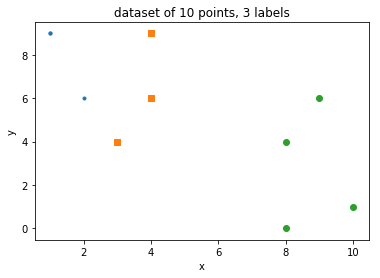

In [76]:
plot2DSet(training_set, "dataset of 10 points, 3 labels")

In [77]:
def display_discretization(labeled_set, threshold, a_j, title):
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold, threshold], [min_v, max_v])
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold, threshold])

    plt.show() 

In [210]:
def display_discretizations_comparison(labeled_set, threshold1, threshold2, threshold, a_j, title, l1, l2, l):
    plot2DSet(labeled_set, title)
    
    if (a_j == 0):
        max_v = ceil(max(labeled_set.x[:,1]))
        min_v = floor(min(labeled_set.x[:,1]))
        plt.plot([threshold1, threshold1], [min_v, max_v], color='green', label=l1)
        plt.plot([threshold2, threshold2], [min_v, max_v], color='red', label=l2)
        if not (threshold is None):
            plt.plot([threshold, threshold], [min_v, max_v], color='black', label=l)
    else:
        max_v = ceil(max(labeled_set.x[:,0]))
        min_v = floor(min(labeled_set.x[:,0]))
        plt.plot([min_v, max_v], [threshold1, threshold1], color='green', label=l1)
        plt.plot([min_v, max_v], [threshold2, threshold2], color='red', label=l2)
        if not (threshold is None):
            plt.plot([min_v, max_v], [threshold, threshold], color='black', label=l)
    
    plt.legend()
    plt.show() 

In [162]:
def discretize(dm, labeled_set):
    '''
        dm : discrimation measure
        labeled_set : labeled set
        
    '''
    a_j = dm.f.a_j
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(dm.value(binary_set))
        
    min_entropy = min(H_values)
    min_threshold = thresholds[np.argmin(H_values)]
    
    return (min_threshold, min_entropy)

splitting value generated by rsdm on axis 0 :  6.0
corresponding entropy :  0.1543719518489275
splitting value generated by sdm on axis 0 :  6.0
corresponding entropy :  0.6000000000000001


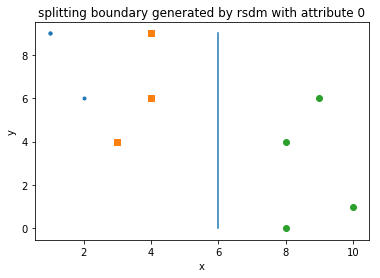

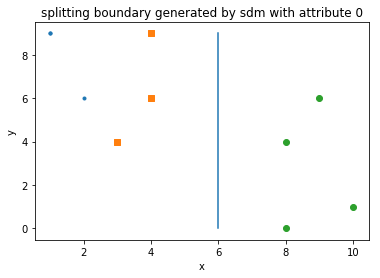

In [79]:
# rsdm 
f = Dsr(0)
g = Log()
h = Sum()

rsdm = Gdm(h, g, f)

# sdm
f = Ds(0)
g = Log()
h = Sum()

sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set)
print("splitting value generated by rsdm on axis 0 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set)
print("splitting value generated by sdm on axis 0 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 0, "splitting boundary generated by rsdm with attribute 0")
display_discretization(training_set, threshold_nr, 0, "splitting boundary generated by sdm with attribute 0")

splitting value generated by rsdm on axis 1 :  0.5
corresponding entropy :  0.78317030992143
splitting value generated by sdm on axis 1 :  5.0
corresponding entropy :  1.2000000000000002


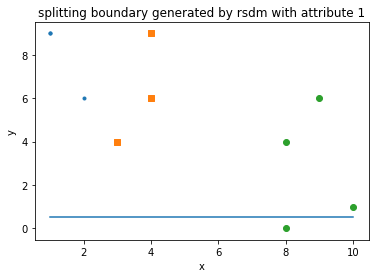

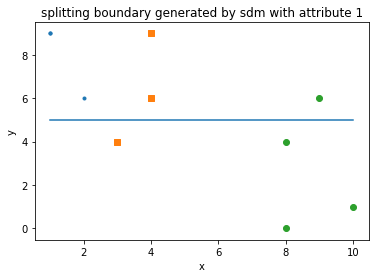

In [80]:
f = Dsr(1)
rsdm = Gdm(h, g, f)

f = Ds(1)
sdm = Gdm(h, g, f)

threshold_r, entropy_r = discretize(rsdm, training_set)
print("splitting value generated by rsdm on axis 1 : ", threshold_r)
print("corresponding entropy : ", entropy_r)

threshold_nr, entropy_nr = discretize(sdm, training_set)
print("splitting value generated by sdm on axis 1 : ", threshold_nr)
print("corresponding entropy : ", entropy_nr)

display_discretization(training_set, threshold_r, 1, "splitting boundary generated by rsdm with attribute 1")
display_discretization(training_set, threshold_nr, 1, "splitting boundary generated by sdm with attribute 1")

In [164]:
import random 
def generate_2Ddataset(a_j, k, n, noise, amplitude, ranges):
    '''
        a_j : monotone attribute
        k : number of labels
        n : number of examples to create 
        noise :  % of non-monotone noise
        amplitude : amplitude of noise
        ranges : array of arrays indicating, for each attribute, its min and max values
    '''
    labeled_set = LabeledSet(2)
    p = round(n/k)
    r = n # remaining examples to add 
    
    current_min = ranges[a_j][0]
    total_range = ranges[a_j][1] - ranges[a_j][0]
    
    thresholds = []
    
    for q in range(k):
        current_max = current_min + (total_range / k) 

        if (current_max > ranges[a_j][1]):
            current_max = ranges[a_j][1]
        
        if (current_max < ranges[a_j][1] and q == k-1):
            current_max = ranges[a_j][1] 
        
        
        if (p < r) and (q==k-1):
            p = r

        
        monotone_values = np.random.uniform(current_min, current_max, size=(p,1))
        
        if noise > 0:
            sample_size = np.random.binomial(len(monotone_values), noise)
            sample = np.random.randint(0, len(monotone_values), size=sample_size)
            
            for e in sample:
                if random.random() < 0.5:
                    val = current_min - random.uniform(0, total_range * amplitude)
                    if (val < ranges[a_j][0]):
                        val = ranges[a_j][0]
                    monotone_values[e] = val
                else:
                    val = current_max + random.uniform(0, total_range * amplitude)
                    if (val > ranges[a_j][1]):
                        val = ranges[a_j][1]
                    monotone_values[e] = val
        
        thresholds.append((current_min,current_max) )
        
        if (a_j == 0):
            random_values = np.random.uniform(ranges[1][0], ranges[1][1], size=(p, 1))
            values = np.hstack((monotone_values, random_values))
        else:
            random_values = np.random.uniform(ranges[0][0], ranges[0][1], size=(p,1))
            values = np.hstack((random_values, monotone_values))
        
        for i in range(p):
            labeled_set.addExample(values[i], q+1)
            
        current_min = current_max
        r -= p 
    return labeled_set, thresholds

### Expérimentation sur des bases de données à deux dimensions

#### 2 classes : 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
splitting value generated by rsdm on axis 0 :  -0.013849712452383756
splitting value generated by sdm on axis 0 :  -0.013849712452383756


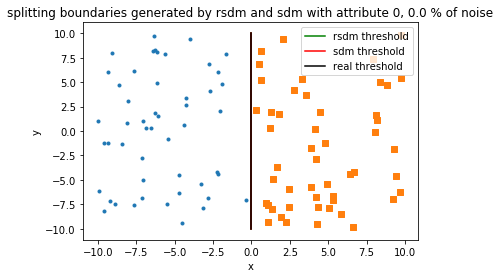

[0.0, 0.0, 0.0, 0.3785578496117912, 0.9627843682561527, 0.0, 1.13547881271078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6323506502443768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0611739410371286, 0.0, 0.0, 0.639108949315988, 0.0, 0.8912387749374308, 0.37010952187551194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34696721905594097, 0.0, 0.26821040962638387, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7309678101516495, 0.0, 1.7863403457800466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
splitting value generated by rsdm on axis 0 :  -0.24310048264944029
splitting value generated by sdm on axis 0 :  -0.24310048264944029


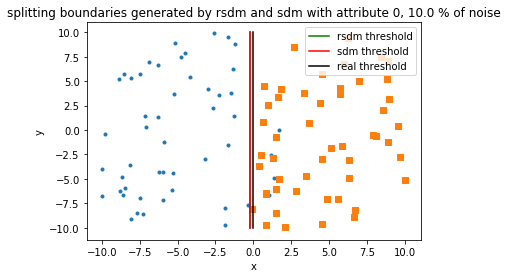

[0.0, 0.10169978329995177, 0.25947479956173625, 2.5307808856543756, 0.384185021008959, 0.0, 0.0, 0.0, 0.0, 2.029264961065267, 2.661400057125202, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6397368862386728, 0.0, 0.6163312258887246, 0.0, 3.315930462479935, 0.0, 1.7003916046809953, 0.0, 1.820891908647457, 0.0, 0.5175610106361243, 0.0, 1.697842582766571, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3189031824748985, 0.516772594040595, 2.3189979109955527, 0.0, 0.31848170507231255, 1.4336923758530147, 2.338848540464263, 1.570341771796882, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9916997206761753, 0.5089059446751989, 2.047260605993473]
splitting value generated by rsdm on axis 0 :  -0.09819919628601936
splitting value generated by sdm on axis 0 :  -0.3576739958477556


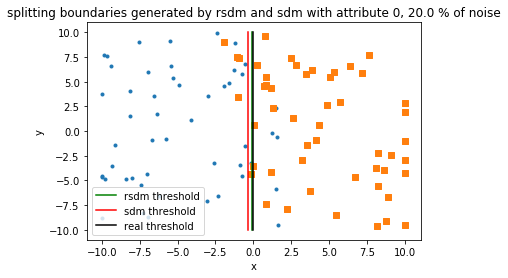

[0.0, 0.3719575259481933, 0.0, 0.0, 0.0, 2.798046522041578, 0.0, 0.2687963650218044, 0.0, 1.8445464414490556, 0.0, 2.021723558943057, 0.0, 0.0, 3.598443577831014, 0.0, 1.8874267456125287, 0.3244342857040441, 2.5937713937214113, 0.0, 0.0, 1.1295775830191195, 0.0, 0.0, 0.903048852469452, 0.0, 0.2844907282588245, 0.0, 2.9634936298777106, 0.0, 0.0, 0.0, 0.0, 3.889155929000114, 0.5236878402201455, 0.0, 2.696959336690422, 1.89876668314228, 0.0, 1.6913632658122584, 0.0, 0.0, 1.8833796092758215, 1.862543654183694, 1.1171461363870048, 0.23041919734382466, 0.386522396925413, 0.0, 0.0, 0.0]
splitting value generated by rsdm on axis 0 :  1.2242783360864737
splitting value generated by sdm on axis 0 :  1.2242783360864737


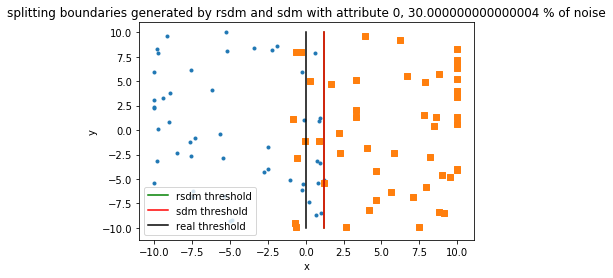

[0.23530079913700908, 3.6922061091442226, 0.0, 3.8954118570002905, 0.9092249555354138, 0.5917724486820881, 0.5908244442182287, 0.0, 1.1647034661749922, 0.16192025817506472, 0.0, 0.2612158280682999, 0.0, 4.008457352108797, 0.0, 2.761239988905437, 0.0, 0.46208986280337205, 0.0, 0.0, 1.173048626331504, 3.573442219729282, 3.0768940088749317, 0.0, 0.28141093543509776, 0.3409596913030055, 3.7744821917749034, 0.6488769427404093, 0.0, 1.6916660344917496, 0.0, 0.4554402372695123, 0.0, 3.3840783276212223, 0.0, 0.0, 3.202014852136072, 0.7513676724825136, 0.0, 0.15550120935141232, 0.3772598774851319, 0.11506864400306482, 1.7353644127005612, 0.0, 0.0, 0.0, 3.868090898501793, 0.644335463370163, 3.089542806238205, 4.25980236397047]
splitting value generated by rsdm on axis 0 :  1.1006641950416063
splitting value generated by sdm on axis 0 :  1.691488639259835


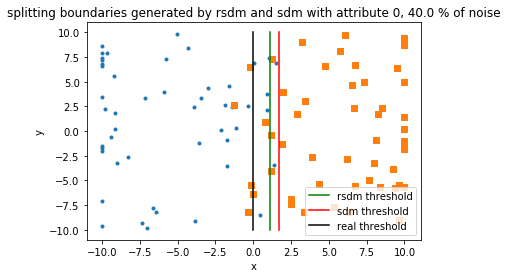

[0.0, 0.0, 0.0, 1.0276241531699724, 4.413573045538018, 0.0, 0.0, 0.11708003174227455, 0.0, 4.013521688759335, 0.0, 3.8595369957114514, 3.4882782986413066, 0.9463741016492713, 0.4629717723755771, 2.8238991627663372, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3591250354403932, 2.802315845135774, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0127646053390236, 0.0, 3.799010582382429, 0.0, 0.0, 0.0, 0.0, 3.7597767800521114, 0.0, 0.34904195580552333, 0.0, 0.330987026904876, 0.0, 1.9940138586859693, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0698801375588276, 0.0, 3.662442572324129]
splitting value generated by rsdm on axis 0 :  -1.865004245208563
splitting value generated by sdm on axis 0 :  -1.865004245208563


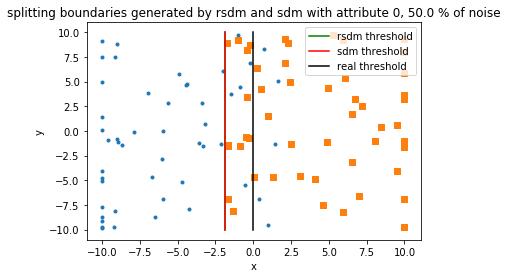

[0.0, 2.779220177276634, 0.0, 3.292413922471031, 0.0, 4.1357256403091425, 4.28540388909168, 0.0, 4.1668782036988805, 0.0, 0.0, 3.1757672086498543, 0.27667300388266014, 0.0, 2.3077803921534366, 0.6366223989944464, 0.0, 0.49418588773059735, 2.8349998996801897, 0.0, 0.3462923122112431, 0.6825517742633278, 0.0, 0.0, 0.0, 4.03261161622636, 0.0, 0.7727731630047134, 4.176154610888703, 4.292954646242908, 0.0, 4.6782765596981815, 0.0, 0.0, 3.4349567981634355, 0.0, 0.0, 3.041753318453292, 4.0785431296501615, 4.028014732852702, 0.0, 0.0, 0.0, 0.0, 4.601193296657464, 0.0, 0.42984554582953827, 0.8504425510856741, 3.948429136680317, 4.1900475140003035]
splitting value generated by rsdm on axis 0 :  1.9871378770602968
splitting value generated by sdm on axis 0 :  1.9871378770602968


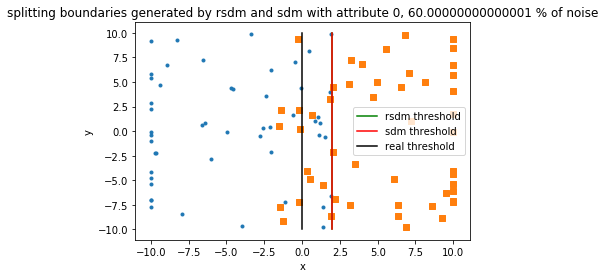

[4.2509401229783155, 0.0, 0.34931670727095, 0.0, 0.0, 0.0, 0.0, 4.368448173994761, 4.0750253371554885, 0.0, 4.317086463846788, 0.0, 0.0, 0.0, 4.190624234983191, 0.0, 0.0, 0.5158166614887771, 0.0, 0.0, 0.0, 3.6194357042797836, 1.4201722321670283, 0.0, 0.0, 0.0, 4.086644979329919, 0.0, 3.7809902098329653, 3.011515446816397, 0.0, 0.0, 0.0, 0.0, 0.0, 3.804422654349973, 0.0, 0.0, 0.44778280489504274, 4.045940071600276, 0.0, 0.0, 3.048928608411886, 4.16940196807358, 0.0, 0.5824506695586082, 0.0, 4.219162745198497, 4.05743672653584, 0.0]
splitting value generated by rsdm on axis 0 :  2.0083873290502514
splitting value generated by sdm on axis 0 :  2.0083873290502514


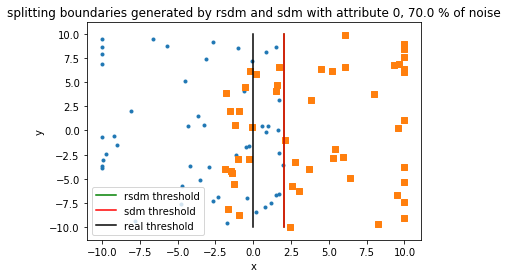

[3.907691331336137, 0.6542813824435054, 4.051325876935576, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.387275655528072, 0.4657410085160065, 0.0, 0.0, 0.0, 4.213972315157399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9855875443459725, 0.0, 0.0, 0.0, 0.0, 3.1456377745004223, 0.0, 0.0, 0.0, 0.4843114206300261, 0.13828458963453172, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.2180069364848025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.17990977479192]
splitting value generated by rsdm on axis 0 :  2.0548835441762874
splitting value generated by sdm on axis 0 :  -1.9964423327592884


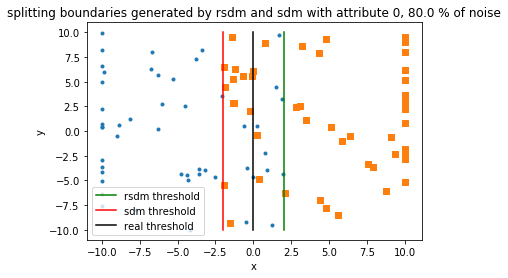

[0.0, 4.192548938607933, 0.0, 4.744353692022937, 0.0, 0.0, 0.0, 4.070180567432861, 0.0, 0.0, 4.421407595432525, 0.0, 0.0, 0.0, 0.0, 3.540106439045825, 0.0, 0.0, 4.88607321541004, 0.0, 0.0, 0.0, 0.0, 4.0699780791572655, 4.371615088425077, 0.0, 0.0, 0.0, 4.274485026492343, 0.0, 3.8454525770236145, 3.3586622490093787, 0.0, 0.0, 0.0, 0.0, 4.139123265649651, 3.5673735469434016, 3.967329177214964, 0.0, 0.0, 0.0, 0.0, 0.0, 4.910760900729004, 3.4760351040215967, 3.914582471763331, 0.0, 0.0, 0.0]
splitting value generated by rsdm on axis 0 :  2.5636905053804675
splitting value generated by sdm on axis 0 :  2.5636905053804675


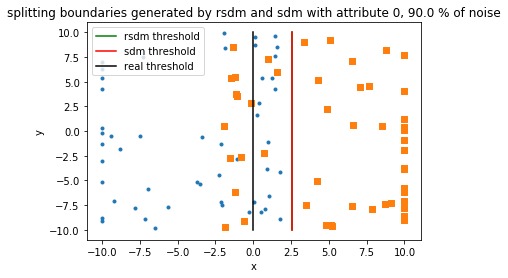

In [204]:
f = Dsr(0)
rsdm = Gdm(h, g, f)

f = Ds(0)
sdm = Gdm(h, g, f)

avg_diff = []
std_diff = []

avg_diff_1 = []
std_diff_1 = []

avg_diff_2 = []
std_diff_2 = []

noises = np.arange(0., 1., 0.1)

threshold = 0

for i in noises:
    thresholds_diff = []
    threshold_diff1 = []
    threshold_diff2 = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        threshold_r, entropy_r = discretize(rsdm, data_set)
        thresholds1.append(threshold_r)
        threshold_diff1.append(fabs(threshold_r - threshold))

        threshold_nr, entropy_nr = discretize(sdm, data_set)
        thresholds2.append(threshold_nr)
        threshold_diff2.append(fabs(threshold_nr - threshold))

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    avg_threshold1 = np.average(thresholds1)
    avg_threshold2 = np.average(thresholds2)
    
    print(thresholds_diff)
    
    print("splitting value generated by rsdm on axis 0 : ", threshold_r)
    print("splitting value generated by sdm on axis 0 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    avg_diff_1.append(np.average(threshold_diff1))
    std_diff_1.append(np.std(threshold_diff1))
    
    avg_diff_2.append(np.average(threshold_diff2))
    std_diff_2.append(np.std(threshold_diff2))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, threshold, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")

In [205]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20

In [206]:
print(avg_diff_norm)
print(std_diff_norm)

[0.         0.01020329 0.0326394  0.0371697  0.05533301 0.04029222
 0.07597051 0.06236154 0.03383203 0.06975007]
[0.         0.02182054 0.046291   0.05468204 0.07231325 0.06952646
 0.09068551 0.08946426 0.07339577 0.09809226]


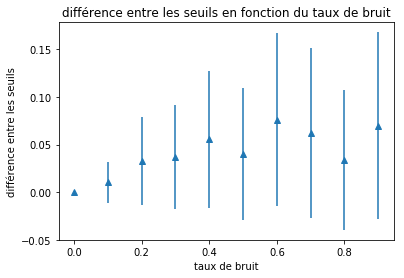

In [207]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre les seuils")
plt.title("différence entre les seuils en fonction du taux de bruit")
plt.show()

splitting value generated by rsdm on axis 1 :  3.44581198899614
splitting value generated by sdm on axis 1 :  8.985468899686367


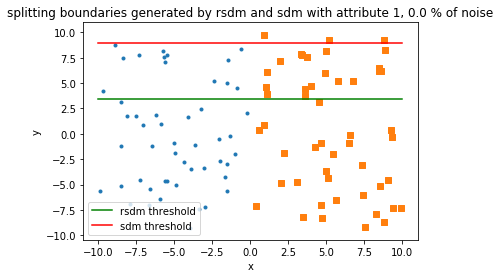

splitting value generated by rsdm on axis 1 :  -9.31769493312278
splitting value generated by sdm on axis 1 :  9.279772265688328


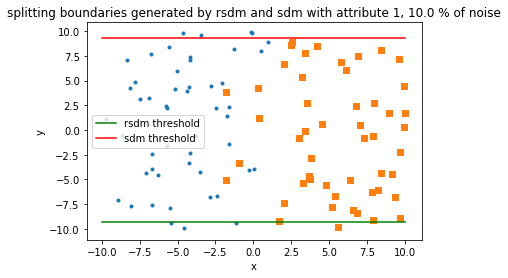

splitting value generated by rsdm on axis 1 :  1.3126644284426572
splitting value generated by sdm on axis 1 :  8.584186300511714


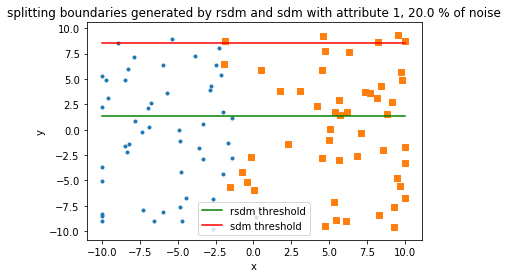

splitting value generated by rsdm on axis 1 :  -0.9001108772323239
splitting value generated by sdm on axis 1 :  9.388895009785452


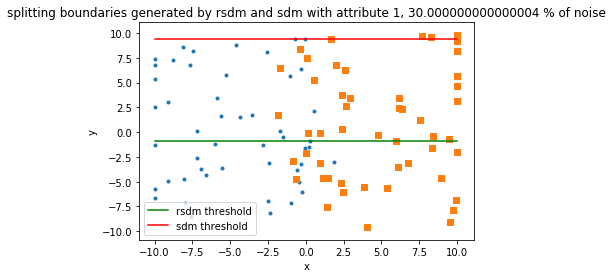

splitting value generated by rsdm on axis 1 :  0.7073046459293231
splitting value generated by sdm on axis 1 :  7.294198530679759


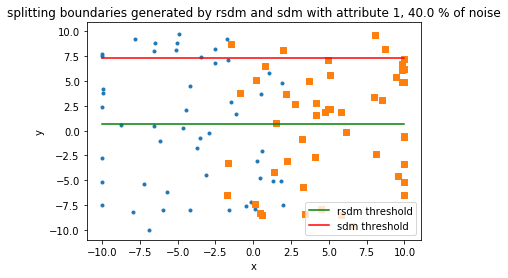

splitting value generated by rsdm on axis 1 :  1.5736406607894295
splitting value generated by sdm on axis 1 :  -7.413902463261717


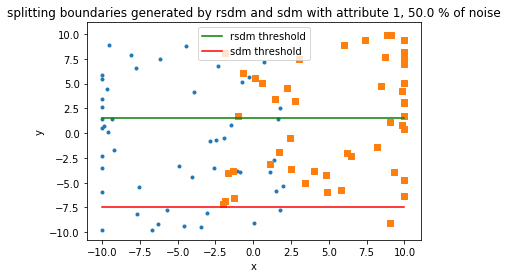

splitting value generated by rsdm on axis 1 :  9.171822101753426
splitting value generated by sdm on axis 1 :  4.846907343171203


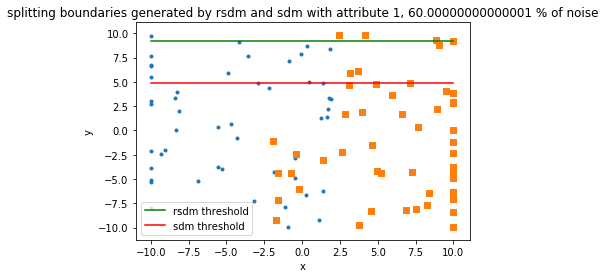

splitting value generated by rsdm on axis 1 :  6.5778927175646125
splitting value generated by sdm on axis 1 :  9.756259180558423


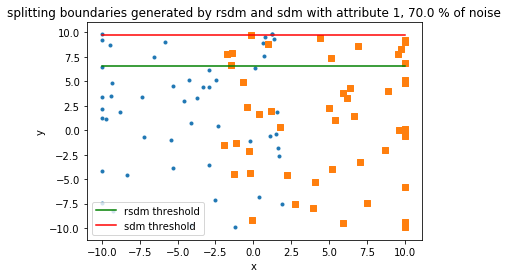

splitting value generated by rsdm on axis 1 :  -9.625973924486736
splitting value generated by sdm on axis 1 :  8.004317793459565


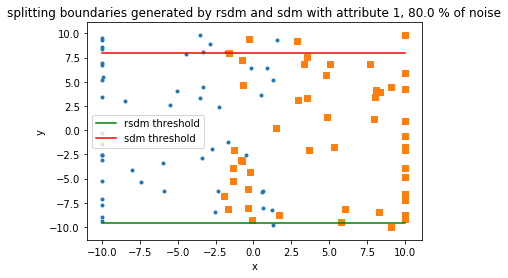

splitting value generated by rsdm on axis 1 :  2.070421336713639
splitting value generated by sdm on axis 1 :  -6.469448889402


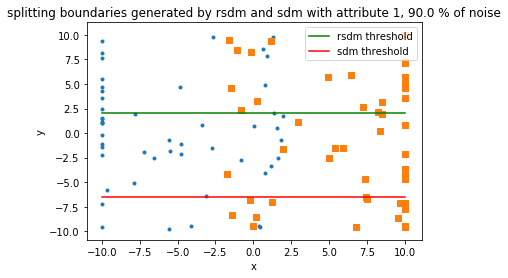

In [211]:
f = Dsr(1)
rsdm = Gdm(h, g, f)

f = Ds(1)
sdm = Gdm(h, g, f)

avg_diff = []
std_diff = []

noises = np.arange(0., 1., 0.1)

for i in noises:
    thresholds_diff = []
    thresholds1 = []
    thresholds2 = []
    datasets = []
    
    for j in range(50):
        data_set, t = generate_2Ddataset(0, 2, 100, i, 0.1, [[-10, 10], [-10, 10]])
        datasets.append(data_set)
        
        threshold_r, entropy_r = discretize(rsdm, data_set)
        thresholds1.append(threshold_r)

        threshold_nr, entropy_nr = discretize(sdm, data_set)
        thresholds2.append(threshold_nr)

        thresholds_diff.append(fabs(threshold_nr - threshold_r))
    
    r = random.choice(np.arange(0, 10))
    data_set = datasets[r]
    threshold_r = thresholds1[r]
    threshold_nr = thresholds2[r]
    
    print("splitting value generated by rsdm on axis 1 : ", threshold_r)
    print("splitting value generated by sdm on axis 1 : ", threshold_nr)
    
    avg_diff.append(np.average(thresholds_diff))
    std_diff.append(np.std(thresholds_diff))
    
    display_discretizations_comparison(data_set, threshold_r, threshold_nr, None, 1, "splitting boundaries generated by rsdm and sdm with attribute 1, " + str(i*100) + " % of noise", "rsdm threshold", "sdm threshold", "real threshold")

In [212]:
avg_diff_norm = np.array(avg_diff) / 20
std_diff_norm = np.array(std_diff) / 20
print(avg_diff_norm)
print(std_diff_norm)

[0.27816702 0.30034182 0.38279398 0.42729783 0.30568217 0.37220705
 0.3544786  0.29750657 0.37543761 0.36718698]
[0.28732838 0.29353082 0.31815785 0.29897848 0.30975604 0.28000564
 0.30152168 0.2832237  0.28808991 0.28008194]


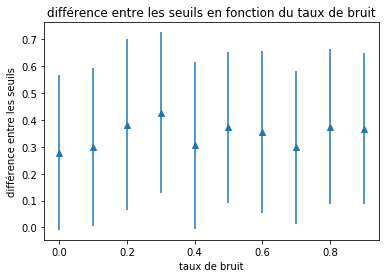

In [213]:
x = noises
y = avg_diff_norm
e = std_diff_norm

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.xlabel("taux de bruit")
plt.ylabel("différence entre les seuils")
plt.title("différence entre les seuils en fonction du taux de bruit")
plt.show()

In [217]:
a_set, t = generate_2Ddataset(0, 2, 100, 0.4, 0.1, [[-10, 10], [-10, 10]])

In [218]:
def discretize_steps(dm, labeled_set):
    '''
        dm : discrimation measure
        labeled_set : labeled set
        
    '''
    a_j = dm.f.a_j
    
    n = labeled_set.size()
    ind = np.argsort(labeled_set.x,axis=0)[:,a_j] # sort values 
    
    binary_set = LabeledSet(labeled_set.getInputDimension())
    binary_set.nb_examples = labeled_set.size()
    binary_set.x = labeled_set.x.copy()
    binary_set.x[:,a_j] = np.ones(labeled_set.size())
    binary_set.y = labeled_set.y
    
    thresholds = []
    H_values = []
    
    for i in range(n-1):
        current = labeled_set.getX(ind[i])[a_j]
        lookahead = labeled_set.getX(ind[i+1])[a_j]
        binary_set.x[ind[i]][a_j] = 0
        
        if current == lookahead:
            continue

        thresholds.append((current + lookahead) / 2.0)
        H_values.append(dm.value(binary_set))
        
    return thresholds, H_values


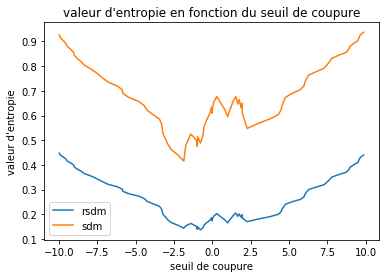

In [223]:
f = Dsr(0)
rsdm = Gdm(h, g, f)

f = Ds(0)
sdm = Gdm(h, g, f)

x, y1 = discretize_steps(rsdm, a_set)
x, y2 = discretize_steps(sdm, a_set)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("seuil de coupure")
plt.ylabel("valeur d'entropie")
plt.title("valeur d'entropie en fonction du seuil de coupure")
plt.legend()
plt.show()

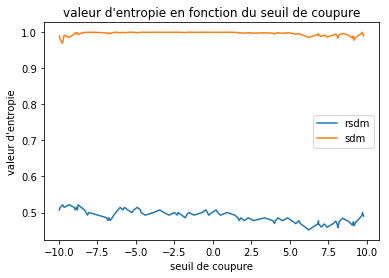

In [224]:
f = Dsr(1)
rsdm = Gdm(h, g, f)

f = Ds(1)
sdm = Gdm(h, g, f)

x, y1 = discretize_steps(rsdm, a_set)
x, y2 = discretize_steps(sdm, a_set)
plt.plot(x, y1, label="rsdm")
plt.plot(x, y2, label="sdm")
plt.xlabel("seuil de coupure")
plt.ylabel("valeur d'entropie")
plt.title("valeur d'entropie en fonction du seuil de coupure")
plt.legend()
plt.show()